<a href="https://colab.research.google.com/github/mswaringen/aml_food/blob/master/KerasTransfer(EfficientNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [57]:
!pip install -U --pre efficientnet

     |████████████████████████████████| 51kB 5.2MB/s 


In [1]:
# import os

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

In [16]:
# # from cloud_tpu_client import Client
# # c = Client()
# # c.configure_tpu_version(tf.__version__, restart_type="always")



import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [58]:
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3
from tensorflow.keras.layers.experimental import preprocessing
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import efficientnet.keras as efn
from tensorflow.keras.models import load_model

In [15]:
# download and unzip locally

downzip=True

if downzip:
  !mkdir data
  %cd data
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV" -O final-project-food-recognition-challenge.zip && rm -rf /tmp/cookies.txt
  !unzip final-project-food-recognition-challenge.zip
  %cd ..
  !mkdir outputs

mkdir: cannot create directory ‘data’: File exists
/content/data
--2020-12-08 11:01:46--  https://docs.google.com/uc?export=download&confirm=jBEX&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV
Resolving docs.google.com (docs.google.com)... 108.177.126.100, 108.177.126.139, 108.177.126.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-4k-docs.googleusercontent.com/docs/securesc/bv2oc8dhubukab6vqu9lkepcb7nobip3/74m2vebdmtolc8hj64ke24q588fom2f1/1607425275000/10490392775048702533/11158179825245729509Z/1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV?e=download [following]
--2020-12-08 11:01:46--  https://doc-10-4k-docs.googleusercontent.com/docs/securesc/bv2oc8dhubukab6vqu9lkepcb7nobip3/74m2vebdmtolc8hj64ke24q588fom2f1/1607425275000/10490392775048702533/11158179825245729509Z/1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV?e=download
Resolving doc-10-4k-docs.googleusercontent.com (doc-10-4k-docs.google

In [61]:
traindf = pd.read_csv('data/train_labels.csv',dtype=str)
testdf = pd.read_csv('data/sample.csv',dtype=str)

datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.20)
batch_size = 32
image_size = (300,300)
NUM_CLASSES = 80
IMG_SIZE = 300

train_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="data/train_set/train_set/",
x_col="img_name",
y_col="label",
subset="training",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=image_size)

valid_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="data/train_set/train_set/",
x_col="img_name",
y_col="label",
subset="validation",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=image_size)

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory="data/test_set/test_set/",
x_col="img_name",
y_col="label",
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=image_size)

Found 24490 validated image filenames belonging to 80 classes.
Found 6122 validated image filenames belonging to 80 classes.
Found 7653 validated image filenames.


In [62]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [63]:
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5",verbose=1,save_best_only=True),
    tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.01,mode = 'min',
    patience=5,verbose = 0, restore_best_weights = True)
]

In [72]:
# with strategy.scope():
#     inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
#     x = img_augmentation(inputs)
#     outputs = EfficientNetB3(include_top=True, weights=None, classes=NUM_CLASSES)(x)

#     model = tf.keras.Model(inputs, outputs)
#     model.compile(
#         optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
#     )

# model.summary()

# epochs = 25 
# hist = model.fit(train_generator, 
#                  epochs=epochs,
#                  validation_data=valid_generator,
#                  callbacks=callbacks, 
#                  verbose=1)

In [66]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
# plot_hist(hist)

In [64]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = efn.EfficientNetB3(include_top=False, input_tensor=x, weights='noisy-student') 
    # model = EfficientNetB3(include_top=False, input_tensor=x, weights="noisy-student")
    # model.load_weights("efficientnet-b3_noisy-student_notop.h5")
    # model.input_tensor(x)
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Epoch 1/25
766/766 [==============================] - ETA: 0s - loss: 4.9989 - accuracy: 0.0555
Epoch 00001: val_loss did not improve from 3.20952
766/766 [==============================] - 102s 134ms/step - loss: 4.9989 - accuracy: 0.0555 - val_loss: 3.2430 - val_accuracy: 0.2306
Epoch 2/25
766/766 [==============================] - ETA: 0s - loss: 3.9420 - accuracy: 0.1523
Epoch 00002: val_loss improved from 3.20952 to 2.59890, saving model to save_at_2.h5
766/766 [==============================] - 100s 130ms/step - loss: 3.9420 - accuracy: 0.1523 - val_loss: 2.5989 - val_accuracy: 0.3616
Epoch 3/25
766/766 [==============================] - ETA: 0s - loss: 3.4968 - accuracy: 0.2134
Epoch 00003: val_loss improved from 2.59890 to 2.35325, saving model to save_at_3.h5
766/766 [==============================] - 100s 131ms/step - loss: 3.4968 - accuracy: 0.2134 - val_loss: 2.3532 - val_accuracy: 0.4188
Epoch 4/25
766/766 [==============================] - ETA: 0s - loss: 3.2672 - accurac

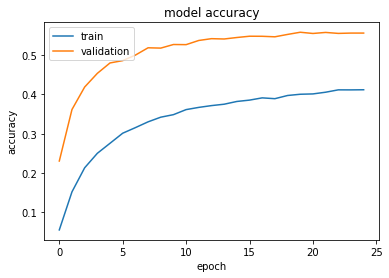

In [67]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)
# model.summary() 
epochs = 25  
hist = model.fit(train_generator, 
                 epochs=epochs,
                 validation_data=valid_generator,
                 callbacks=callbacks, 
                 verbose=1)
plot_hist(hist)

Epoch 1/10
766/766 [==============================] - 103s 134ms/step - loss: 2.2381 - accuracy: 0.4370 - val_loss: 1.6686 - val_accuracy: 0.5864
Epoch 2/10
766/766 [==============================] - 101s 131ms/step - loss: 2.1420 - accuracy: 0.4592 - val_loss: 1.6344 - val_accuracy: 0.5943
Epoch 3/10
766/766 [==============================] - 101s 132ms/step - loss: 2.0839 - accuracy: 0.4717 - val_loss: 1.6096 - val_accuracy: 0.5982
Epoch 4/10
766/766 [==============================] - 100s 131ms/step - loss: 2.0371 - accuracy: 0.4780 - val_loss: 1.5920 - val_accuracy: 0.6052
Epoch 5/10
766/766 [==============================] - 100s 131ms/step - loss: 1.9847 - accuracy: 0.4902 - val_loss: 1.5679 - val_accuracy: 0.6101
Epoch 6/10
766/766 [==============================] - 101s 131ms/step - loss: 1.9429 - accuracy: 0.4974 - val_loss: 1.5625 - val_accuracy: 0.6117
Epoch 7/10
766/766 [==============================] - 100s 130ms/step - loss: 1.9074 - accuracy: 0.5070 - val_loss: 1.5391 -

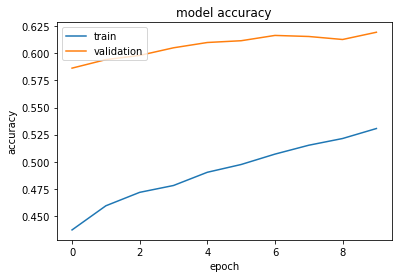

In [68]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10  
hist = model.fit(train_generator, epochs=epochs, validation_data=valid_generator, verbose=1)
plot_hist(hist)

In [70]:
loss, accuracy = model.evaluate(valid_generator)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

192/192 [==============================] - 20s 102ms/step - loss: 1.5117 - accuracy: 0.6196
Validation: accuracy = 0.619569  ;  loss = 1.511702 


In [71]:
test_generator.reset()

pred=model.predict(test_generator,
steps=test_generator.n//test_generator.batch_size,
verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results=pd.DataFrame({"img_name":filenames,
                      "label":predictions})
results.to_csv("results.csv",index=False)

7653/7653 [==============================] - 107s 14ms/step
